In [22]:
# 必要なライブラリの読み込み
from scipy.stats import binom
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set_theme()

In [23]:
# bayes-1.csvファイルのデータを読み込み
data1 = pd.read_csv('./bayes-1.csv')
data1.head()

,N,y,x,f
0,8,1,9.76,C
1,8,6,10.48,C
2,8,5,10.83,C
3,8,6,10.94,C
4,8,1,9.37,C


<Axes: xlabel='x', ylabel='y'>

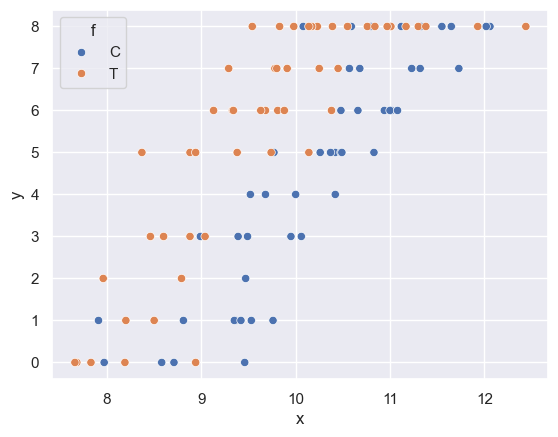

In [24]:
# 散布図を描画
sns.scatterplot(x="x", y="y", data=data1, hue='f')

In [25]:
# 発芽能力の無い種子数のカラム ny を追加
data1['ny'] = data1['N'] - data1['y']

# 一般化線形モデル（ロジスティック回帰モデル）
model1 = smf.glm(formula='y + ny ~ x + f', data=data1, family=sm.families.Binomial()).fit()
print(model1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            ['y', 'ny']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -133.11
Date:                Fri, 23 May 2025   Deviance:                       123.03
Time:                        11:21:58   Pearson chi2:                     109.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9768
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.5361      1.414    -13.818      0.0

In [5]:
# 肥料を与えた場合と与えなかった場合でデータを分割
data1_C = data1.query('f == "C"')
data1_T = data1.query('f == "T"')

Text(0, 0.5, 'y: # of Seeds (Alive)')

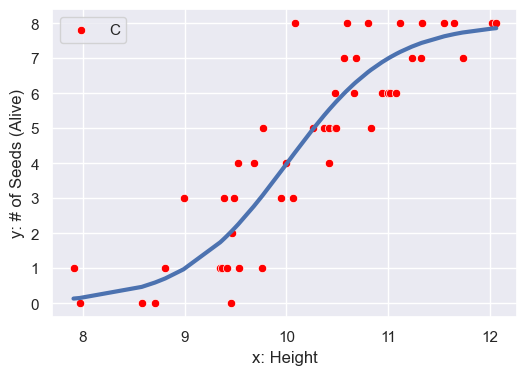

In [6]:
# xの昇順でdata1_Cのデータを並べ替え
data1_C = data1_C.sort_values('x')

# xとfの値を使って予測を実行
pred1 = model1.predict(data1_C[['x','f']])

# Cのみの散布図にpred1の線を描画
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(x="x", y="y", data=data1_C, color='red', label='C', ax=ax)
ax.plot(data1_C['x'], 8*pred1, lw=3)    # 8倍しているのは、予測値が0〜1までの実数値であり、種子数に合わせるため
ax.set_xlabel('x: Height')
ax.set_ylabel('y: # of Seeds (Alive)')

Text(0, 0.5, 'y: # of Seeds (Alive)')

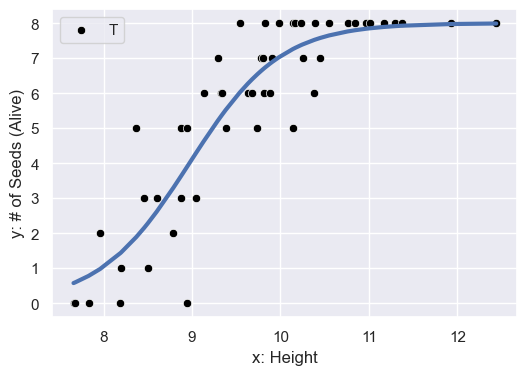

In [7]:
# xの昇順でdata1_Tのデータを並べ替え
data1_T = data1_T.sort_values('x')

# xとfの値を使って予測を実行
pred2 = model1.predict(data1_T[['x','f']])

# Tのみの散布図にpred2の線を描画
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(x="x", y="y", data=data1_T, color='black', label='T', ax=ax)
ax.plot(data1_T['x'], 8*pred2, lw=3)    # 8倍しているのは、予測値が0〜1までの実数値であり、種子数に合わせるため
ax.set_xlabel('x: Height')
ax.set_ylabel('y: # of Seeds (Alive)')

In [8]:
# PyMCで利用するライブラリを追加でimport
import arviz as az
import numpy as np
import pymc as pm

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [9]:
# fの値をC→0, T→1へ変更（便宜上の処理）
data1['f'] = (np.array([0]*50 + [1]*50)).astype(np.float64)

# データの準備
J  = data1.shape[0]  # グループの数
N  = data1['N']      # N列のデータ
x  = data1['x']      # x列のデータ
f  = data1['f']      # f列のデータ
y  = data1['y']      # y列のデータ
ny = data1['ny']     # ny列のデータ

In [10]:
with pm.Model() as stmodel1:    # y = β0 + β1x + β2f のモデルを定義
    # パラメータの定義
    # 事前分布（仮定の分布）として平均0・分散100の正規分布を指定
    beta_0 = pm.Normal('beta_0', mu=0, sigma=100)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=100)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=100)

    # リンク関数（ロジット関数）の定義
    theta = pm.math.invlogit(beta_0 + beta_1 * x + beta_2 * f)

    # データに対する確率分布（二項分布）の定義
    y_obs = pm.Binomial('y_obs', n=8, p=theta, observed=y)

    # 乱数種の設定
    random_seed = 0

    # NUTSアルゴリズムを使ってサンプリングの実行
    fit = pm.sample(random_seed=random_seed)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, beta_2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1164 seconds.


In [11]:
# サンプリング結果の概要を表示
print(az.summary(fit))

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_0 -19.695  1.462 -22.587  -17.117      0.051    0.046     834.0   
beta_1   1.969  0.143   1.722    2.257      0.005    0.004     844.0   
beta_2   2.028  0.239   1.592    2.486      0.008    0.005    1005.0   

        ess_tail  r_hat  
beta_0     870.0   1.00  
beta_1     862.0   1.00  
beta_2    1236.0   1.01  


In [12]:
# bayes-2.csvファイルのデータを読み込み
data2 = pd.read_csv('bayes-2.csv')
data2.head()

,N,y,x,id
0,8,0,2,1
1,8,1,2,2
2,8,2,2,3
3,8,4,2,4
4,8,1,2,5


In [ ]:
# 発芽能力の無い種子数のカラム ny を追加
data2['ny'] = data2['N'] - data2['y']

# 一般化線形モデル（ロジスティック回帰モデル）
model2 = smf.glm(formula='y + ny ~ x', data=data2, family=sm.families.Binomial()).fit()
print(model2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            ['y', 'ny']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -322.80
Date:                Fri, 23 May 2025   Deviance:                       513.84
Time:                        10:35:49   Pearson chi2:                     428.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.6078
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1487      0.237     -9.057      0.0

Text(0, 0.5, 'y: # of Seeds (Alive)')

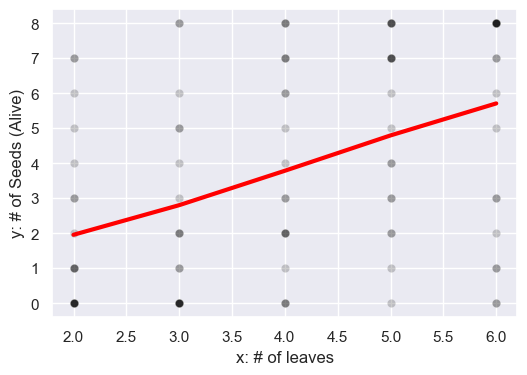

In [14]:
# 散布図と回帰直線を描画
data2_sorted = data2.sort_values('x')
pred2 = model2.predict(data2_sorted['x'])

fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(x="x", y="y", data=data2, alpha=0.2, color='black', ax=ax)

ax.plot(data2_sorted['x'], pred2*8, color='red', lw=3)
ax.set_xlabel('x: # of leaves')
ax.set_ylabel('y: # of Seeds (Alive)')

Text(0, 0.5, '# of individuals')

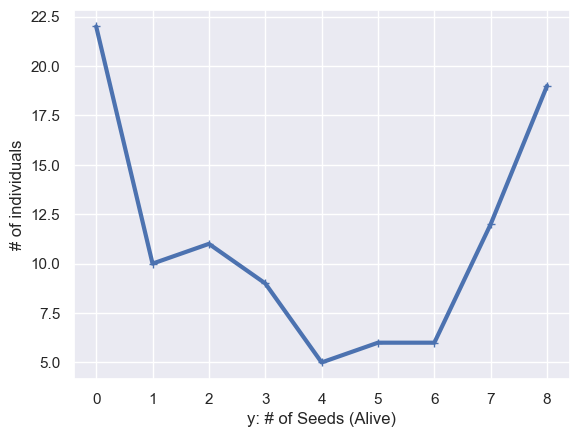

In [15]:
# 生存種子数と個体数のグラフを描画
count_y = data2.groupby('y').count()['id']

plt.plot(count_y.index, count_y.values, marker='+', lw=3)
plt.xlabel('y: # of Seeds (Alive)')
plt.ylabel('# of individuals')

In [16]:
# 葉の枚数が4枚の個体について、種子数ごとに個体数を集計
leaves_4 = data2.query('x == 4').groupby('y').count()['id']
leaves_4

y
0    3
1    1
2    4
3    2
4    1
5    1
6    2
7    3
8    3
Name: id, dtype: int64

Text(0, 0.5, '# of individuals')

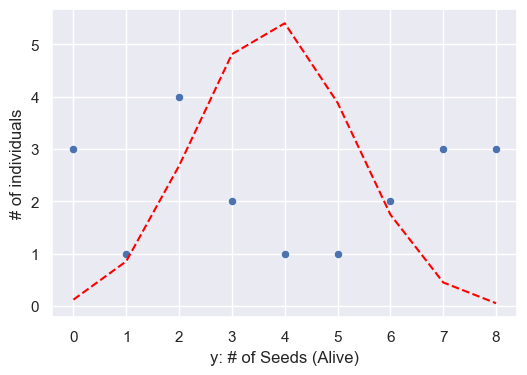

In [17]:
# 葉の枚数が4枚の場合の実測値と予測結果を比較
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(x=leaves_4.index, y=leaves_4.values, ax=ax)     # 実測値の描画

# モデルの数式
def logistic(beta0, beta1, x):
    return 1 / (1 + math.exp(-(beta0 + beta1*x)))

q = logistic(model2.params['Intercept'], model2.params['x'], 4) # 予測値の取得
y = np.arange(9)

# 予測値の描画
ax.plot(y, [binom.pmf(y_i, 8, q)*20 for y_i in y], label='predicted', color='red', linestyle='--')
ax.set_xlabel('y: # of Seeds (Alive)')
ax.set_ylabel('# of individuals')

In [18]:
# 葉の数が4枚の場合の種子数の平均と分散
data2_l4 = data2.query('x == 4')
print('平均:', data2_l4['y'].mean())
print('分散:', data2_l4['y'].var())

平均: 4.05
分散: 8.365789473684211


In [19]:
# データの準備
J  = data2.shape[0]  # グループの数
N  = data2['N']        # N列のデータ
y  = data2['y']        # y列のデータ
x  = data2['x']        # x列のデータ
id = data2['id']       # id列のデータ
ny = data2['ny']       # ny列のデータ

In [20]:
with pm.Model() as stmodel1:    # 一般化線形混合モデルを定義
    # パラメータの定義
    # 事前分布（仮定の分布）として平均0・分散100の正規分布を指定
    beta_0 = pm.Normal('beta_0', mu=0, sigma=100)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=100)
    s = pm.Uniform('s', lower=0, upper=1000)

    # 個体差
    r = pm.Normal('r', mu=0, sigma=s, shape=J)

    # リンク関数（ロジット関数）の定義
    p = pm.math.invlogit(beta_0 + beta_1 * x + r)

    # データに対する確率分布（二項分布）の定義
    y_obs = pm.Binomial('y_obs', n=8, p=p, observed=y)

    # 乱数種の設定
    random_seed = 0

    # NUTSアルゴリズムを使ってサンプリングの実行
    fit = pm.sample(random_seed=random_seed)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, s, r]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1638 seconds.


In [21]:
# サンプリング結果の概要を表示
print(az.summary(fit))

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta_0 -4.322  0.980  -6.003   -2.351      0.047    0.031     455.0     841.0   
beta_1  1.037  0.230   0.615    1.463      0.010    0.007     499.0     799.0   
r[0]   -2.042  1.852  -5.747    0.944      0.031    0.041    4141.0    2138.0   
r[1]   -0.062  1.186  -2.299    2.093      0.029    0.020    1713.0    2766.0   
r[2]    0.879  1.030  -1.129    2.716      0.028    0.017    1336.0    1908.0   
...       ...    ...     ...      ...        ...      ...       ...       ...   
r[96]  -1.224  0.934  -2.936    0.580      0.024    0.015    1540.0    1987.0   
r[97]   0.363  1.203  -1.892    2.586      0.024    0.022    2515.0    2445.0   
r[98]  -2.860  0.934  -4.767   -1.248      0.024    0.016    1541.0    2106.0   
r[99]   2.243  1.791  -1.034    5.535      0.030    0.042    4031.0    2418.0   
s       2.658  0.331   2.096    3.315      0.012    0.007     822.0    1423.0   

        r_hat  
beta_0   1.